In [2]:
# Extract ERP for each year (Estimated Residential Population)
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

erp_predicted = spark.read.csv("../../generic-real-estate-consulting-project-group-43/data/curated/feature_prediction/22_27_population.csv", header=True)

erp_predicted = erp_predicted.withColumn("pred",erp_predicted["pred"].cast(IntegerType()))

erp_predicted.printSchema()

# Victoria state data only
erp_agg = erp_predicted.groupBy('year').sum('pred').alias('pred')

erp_agg.withColumnRenamed("sum(pred)","pred")

plt.plot(erp_agg['year'],erp_agg['pred'])
plt.title('title name')
plt.xlabel('Year')
plt.ylabel('ERP Predicted')
plt.show()

22/09/26 15:57:54 WARN Utils: Your hostname, Hyunjin-Win11 resolves to a loopback address: 127.0.1.1; using 172.24.195.83 instead (on interface eth0)
22/09/26 15:57:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/26 15:57:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- _c0: string (nullable = true)
 |-- year: string (nullable = true)
 |-- SA2 code: string (nullable = true)
 |-- pred: integer (nullable = true)



AnalysisException: Cannot resolve column name "pred" among (year, sum(pred))

22/09/26 15:24:33 WARN Utils: Your hostname, Hyunjin-Win11 resolves to a loopback address: 127.0.1.1; using 172.24.195.83 instead (on interface eth0)
22/09/26 15:24:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/26 15:24:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- sa2_name_2016: string (nullable = true)
 |-- sa2_maincode_2016: string (nullable = true)
 |-- erp_2013: integer (nullable = true)
 |-- erp_2014: integer (nullable = true)
 |-- erp_2015: integer (nullable = true)
 |-- erp_2016: integer (nullable = true)
 |-- erp_2017: integer (nullable = true)
 |-- erp_2018: integer (nullable = true)
 |-- erp_2019: integer (nullable = true)
 |-- erp_2020: integer (nullable = true)
 |-- erp_2021: integer (nullable = true)



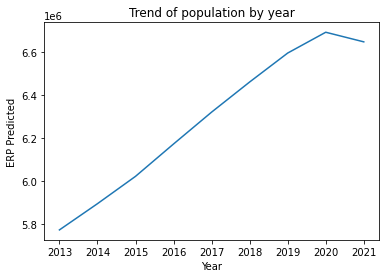

In [1]:
# Extract ERP for each year (Estimated Residential Population)
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt

erp_predicted = spark.read.csv("../../generic-real-estate-consulting-project-group-43/data/curated/erp_vic.csv", header=True)

erp_predicted = erp_predicted.withColumn("erp_2013",erp_predicted["erp_2013"].cast(IntegerType()))\
                                .withColumn("erp_2014",erp_predicted["erp_2014"].cast(IntegerType()))\
                                .withColumn("erp_2015",erp_predicted["erp_2015"].cast(IntegerType()))\
                                .withColumn("erp_2016",erp_predicted["erp_2016"].cast(IntegerType()))\
                                .withColumn("erp_2017",erp_predicted["erp_2017"].cast(IntegerType()))\
                                .withColumn("erp_2018",erp_predicted["erp_2018"].cast(IntegerType()))\
                                .withColumn("erp_2019",erp_predicted["erp_2019"].cast(IntegerType()))\
                                .withColumn("erp_2020",erp_predicted["erp_2020"].cast(IntegerType()))\
                                .withColumn("erp_2021",erp_predicted["erp_2021"].cast(IntegerType()))

erp_predicted.printSchema()

# Graph the erp trend line to decide how to predict erp from 2022 - 2027
erp_agg = erp_predicted.groupby().sum().toPandas()

year = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

y_axis = erp_agg.iloc[0]

plt.plot(year,y_axis)
plt.title('Trend of population by year')
plt.xlabel('Year')
plt.ylabel('ERP Predicted')
plt.show()

22/09/26 16:08:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , year, month, address, latitude, longitude, postcode, sa2_2021, sa2_2016, residence_type, nbed, nbath, ncar, min_distance_to_cbd, min_distance_to_park, min_distance_to_prim, min_distance_to_second, min_distance_to_train, min_distance_to_hosp, min_distance_to_poli, min_distance_to_shop, weekly_rent, gdp(USD Millioins), saving_rate(% of GDP), income_per_person, population, crime_cases, erp
 Schema: _c0, year, month, address, latitude, longitude, postcode, sa2_2021, sa2_2016, residence_type, nbed, nbath, ncar, min_distance_to_cbd, min_distance_to_park, min_distance_to_prim, min_distance_to_second, min_distance_to_train, min_distance_to_hosp, min_distance_to_poli, min_distance_to_shop, weekly_rent, gdp(USD Millioins), saving_rate(% of GDP), income_per_person, population, crime_cases, erp
Expected: _c0 but found: 
CSV file: file:///home/hyunjinp/generic-real-estate-consulting-project-group-43/data/

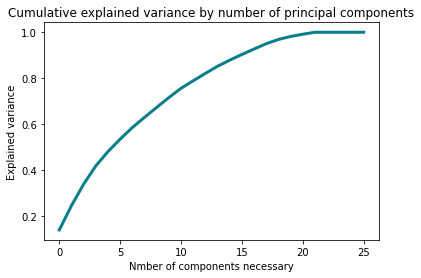

In [17]:
# Scrutinize the data with PCA: Test the attribute relevance
from heapq import merge
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

merged_df = spark.read.csv("../../generic-real-estate-consulting-project-group-43/data/curated/merged_dataset/2013_merged_data.csv", header=True)
for c in merged_df.columns:
    if (c not in  ['address', 'residence_type']):
        merged_df = merged_df.withColumn(c,merged_df[c].cast(IntegerType())) 

merged_df = merged_df.toPandas()

merged_df['residence_type'] = merged_df['residence_type'].astype('category')
merged_df['residence_type'] = merged_df['residence_type'].cat.codes

merged_df.iloc[:, 13:21] = merged_df.iloc[:, 13:21].replace(np.nan, 99999)

merged_df = merged_df.dropna()

X = merged_df.drop(['address', 'weekly_rent'], axis=1)
y = merged_df['weekly_rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

pca = PCA().fit(X_train_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components')
plt.xlabel("Nmber of components necessary")
plt.ylabel("Explained variance")
plt.show()

In [21]:
# Scrutinize the data with PCA: Test the attribute relevance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols

merged_df.rename(columns = {'gdp(USD Millioins)':'gdp', 'saving_rate(% of GDP)':'saving_rate'}, inplace = True)

# OLS Regression
# External ----------------------------------------------------------------------------------------------------
external_model = ols(formula = 'weekly_rent ~ sa2_2021 + min_distance_to_cbd + \
    min_distance_to_park + min_distance_to_prim + min_distance_to_second + min_distance_to_train +\
    min_distance_to_hosp + min_distance_to_poli + min_distance_to_shop + gdp + saving_rate + income_per_person + population +\
    crime_cases + erp', data = merged_df).fit()

# Summary of external factors
ex_summary = external_model.summary()

print("Summary of external factors: ")
print(ex_summary)

# Anova table of external factors
ex_anova_table = sm.stats.anova_lm(external_model, typ=2)

print("Anova table of external factors: ")
print(ex_anova_table)

# Internal ----------------------------------------------------------------------------------------------------
internal_model = ols(formula = 'weekly_rent ~ residence_type + nbed + nbath + ncar', data = merged_df).fit()

# Summary of internal factors
in_summary = internal_model.summary()

print("Summary of internal factors: ")
print(in_summary)

# Anova table of internal factors
in_anova_table = sm.stats.anova_lm(internal_model, typ=2)

print("Anova table of internal factors: ")
print(in_anova_table)

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     238.0
Date:                Mon, 26 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:13:14   Log-Likelihood:                -68687.
No. Observations:               10933   AIC:                         1.374e+05
Df Residuals:                   10919   BIC:                         1.375e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------